In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("car_price_prediction.csv")

In [5]:
missing_pct = (df.isna().sum() / len(df)) * 100
missing_pct.sort_values(ascending=False)

ID                  0.0
Price               0.0
Color               0.0
Wheel               0.0
Doors               0.0
Drive wheels        0.0
Gear box type       0.0
Cylinders           0.0
Mileage             0.0
Engine volume       0.0
Fuel type           0.0
Leather interior    0.0
Category            0.0
Prod. year          0.0
Model               0.0
Manufacturer        0.0
Levy                0.0
Airbags             0.0
dtype: float64

In [7]:
threshold = 0.8

In [9]:
corr_matrix = df.select_dtypes(include="number").corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
)

high_corr_pairs[high_corr_pairs["correlation"] > 0.8] \
    .sort_values("correlation", ascending=False)

,feature_1,feature_2,correlation


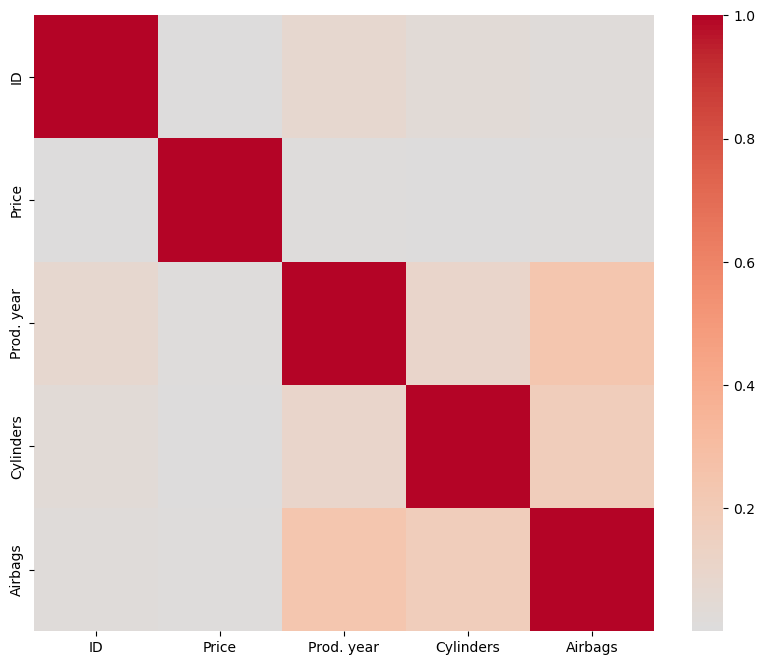

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.show()

In [12]:
# dtype of every column
dtypes = df.dtypes.sort_index()
print(dtypes)

# quick counts by dtype
print(df.dtypes.value_counts())

Airbags               int64
Category             object
Color                object
Cylinders           float64
Doors                object
Drive wheels         object
Engine volume        object
Fuel type            object
Gear box type        object
ID                    int64
Leather interior     object
Levy                 object
Manufacturer         object
Mileage              object
Model                object
Price                 int64
Prod. year            int64
Wheel                object
dtype: object
object     13
int64       4
float64     1
Name: count, dtype: int64


In [15]:
y = df["Price"]
X = df.drop(columns=["Price", "ID"])

In [23]:
# Doors
X["Doors"] = pd.to_numeric(
    X["Doors"].astype("string").str.extract(r"(\d+)")[0],
    errors="coerce"
)

# Mileage: "120000 km" -> 120000
X["Mileage"] = pd.to_numeric(
    X["Mileage"].astype("string").str.replace(r"[^\d.]", "", regex=True),
    errors="coerce"
)

# Engine volume: "2.0 Turbo" -> 2.0
X["Engine volume"] = pd.to_numeric(
    X["Engine volume"].astype("string").str.extract(r"(\d+\.?\d*)")[0],
    errors="coerce"
)

X["Levy"] = (
    X["Levy"]
    .astype("string")                               # handles mixed types safely
    .str.replace(r"[^\d.]", "", regex=True)          # keep digits + dot
)

X["Levy"] = pd.to_numeric(X["Levy"], errors="coerce")

In [25]:
X["Leather interior"] = X["Leather interior"].map({"Yes": 1, "No": 0})

In [27]:
cat_cols = X.select_dtypes(include=["object"]).columns

X = pd.get_dummies(
    X,
    columns=cat_cols,
    dummy_na=True
)


In [29]:
# All features must be numeric
assert X.select_dtypes(include=["object"]).shape[1] == 0

print(X.dtypes.value_counts())


bool       1705
Float64       3
int64         3
float64       1
Int64         1
Name: count, dtype: int64


In [31]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.0)  # 0.0 removes constants only
X_vt = vt.fit_transform(X)

kept_cols = X.columns[vt.get_support()]
X = pd.DataFrame(X_vt, columns=kept_cols, index=X.index)
print("Kept columns:", X.shape[1])

Kept columns: 1705


In [33]:
X = X.loc[:, ~X.T.duplicated()]
print("After dropping duplicate columns:", X.shape[1])

After dropping duplicate columns: 1695


In [39]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 16.7 MB/s eta 0:00:05
   -- ------------------------------------- 5.2/72.0 MB 18.8 MB/s eta 0:00:04
   ---- ----------------------------------- 8.7/72.0 MB 17.9 MB/s eta 0:00:04
   ------ --------------------------------- 11.8/72.0 MB 16.4 MB/s eta 0:00:04
   -------- ------------------------------- 14.7/72.0 MB 17.1 MB/s eta 0:00:04
   --------- ------------------------------ 17.6/72.0 MB 15.4 MB/s eta 0:00:04
   ----------- ---------------------------- 20.2/72.0 MB 14.8 MB/s eta 0:00:04
   ------------ --------------------------- 22.3/72.0 MB 14.4 MB/s eta 0:00:04
   -------------- ------------------------- 25.7/72.0 MB 14.4 MB/s eta 0:00:04
   ---------------- ----------------------- 28.8/72.0 MB 14.5 MB/s eta 0:00:03
   ----------------- ---------------------- 32.2/72.0 MB 14.5 MB/s eta 0:00:03
   -------------------- ------------------- 36.2/72.0 MB 14.8 MB

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

perm = permutation_importance(
    model, X_val, y_val,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

imp_perm = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
top_k = 300
selected_features = imp_perm.head(top_k).index.tolist()

X_sel = X[selected_features]
print("Selected features:", X_sel.shape[1])


Selected features: 300


In [43]:
booster = model.get_booster()
gain_dict = booster.get_score(importance_type="gain")

gain_encoded = (
    pd.Series(gain_dict)
      .rename("gain")
      .sort_values(ascending=False)
)

In [45]:
# original categorical columns BEFORE encoding
categorical_cols = [
    "Category","Color","Doors","Drive wheels","Engine volume",
    "Fuel type","Gear box type","Leather interior","Levy",
    "Manufacturer","Mileage","Model","Wheel"
]

def map_to_base_feature(col):
    for base in categorical_cols:
        if col.startswith(base + "_"):
            return base
    return col  # numeric features map to themselves


In [47]:
gain_feature_level = (
    gain_encoded
    .groupby(map_to_base_feature)
    .sum()
    .sort_values(ascending=False)
)

gain_feature_level.head(15)


Manufacturer     4.836166e+12
Prod. year       2.698230e+12
Model            1.744297e+12
Color            1.603665e+12
Airbags          1.250688e+12
Doors            6.985438e+11
Mileage          3.862055e+11
Engine volume    2.858502e+11
Category         2.446376e+11
Levy             1.069989e+11
Gear box type    3.509351e+10
Fuel type        2.864890e+10
Drive wheels     1.995081e+10
Cylinders        4.705367e+09
Wheel            4.145528e+09
Name: gain, dtype: float64

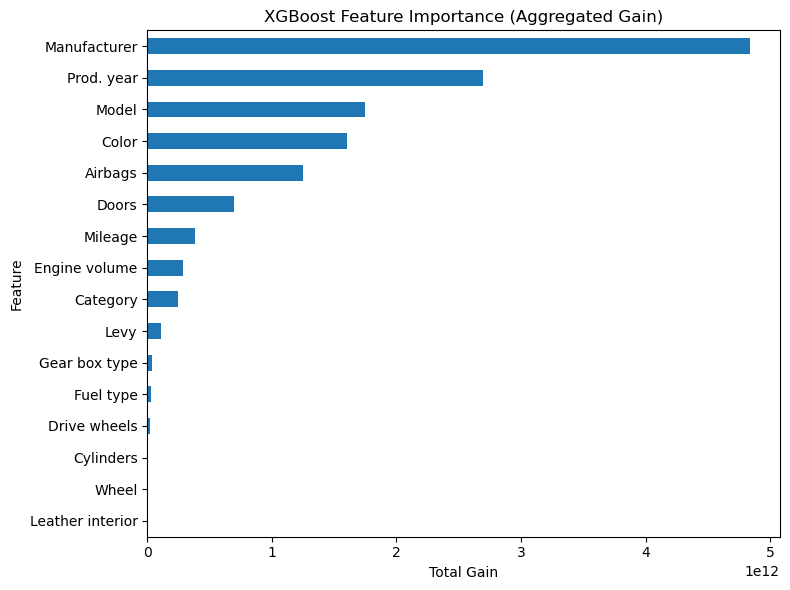

In [49]:
import matplotlib.pyplot as plt

top_n = 20

gain_feature_level.head(top_n).iloc[::-1].plot(
    kind="barh",
    figsize=(8, 6),
    title="XGBoost Feature Importance (Aggregated Gain)"
)

plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [61]:
dtrain = xgb.DMatrix(
    X_train,
    label=y_train,
    feature_names=list(X_train.columns)  
)

dval = xgb.DMatrix(
    X_val,
    label=y_val,
    feature_names=list(X_val.columns)   
)

In [63]:



params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 5,
    "lambda": 1.0,
    "alpha": 0.0,
    "seed": 42,
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1200,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=100,
    verbose_eval=100
)


[0]	train-rmse:211982.51291	val-rmse:17655.54144
[100]	train-rmse:163270.47792	val-rmse:34269.78583
[107]	train-rmse:161391.57673	val-rmse:34636.59784


In [65]:
# Predict directly (already in original price scale)
y_val_pred = model.predict(dval)


In [67]:
import pandas as pd

results = pd.DataFrame({
    "actual_price": y_val.values,
    "predicted_price": y_val_pred
})

results.head(10)


,actual_price,predicted_price
0,27284,17753.076172
1,10349,12986.662109
2,40769,8410.382812
3,38737,33280.886719
4,42102,33902.058594
5,42400,38032.492188
6,18817,15972.897461
7,12858,11607.941406
8,10820,11585.875000
9,15367,16307.600586


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rmse = mean_squared_error(
    results["actual_price"],
    results["predicted_price"],
    squared=False
)

mae = mean_absolute_error(
    results["actual_price"],
    results["predicted_price"]
)

r2 = r2_score(
    results["actual_price"],
    results["predicted_price"]
)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE:  {mae:,.0f}")
print(f"R²:   {r2:.3f}")


RMSE: 34,637
MAE:  8,807
R²:   -2.847


C:\Users\manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
y_train_pred = model.predict(dtrain)


In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_train_pred = model.predict(dtrain)
y_val_pred   = model.predict(dval)

# Metrics
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse   = mean_squared_error(y_val,   y_val_pred,   squared=False)

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae   = mean_absolute_error(y_val,   y_val_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2   = r2_score(y_val,   y_val_pred)

print(f"Train RMSE: {train_rmse:,.2f} | Val RMSE: {val_rmse:,.2f}")
print(f"Train MAE:  {train_mae:,.2f} | Val MAE:  {val_mae:,.2f}")
print(f"Train R²:   {train_r2:.4f} | Val R²:   {val_r2:.4f}")

# Simple overfitting signal (ratio)
print(f"RMSE ratio (Val/Train): {val_rmse/train_rmse:.2f}")


Train RMSE: 161,391.58 | Val RMSE: 34,636.60
Train MAE:  10,066.17 | Val MAE:  8,807.02
Train R²:   0.4253 | Val R²:   -2.8474
RMSE ratio (Val/Train): 0.21


C:\Users\manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\manal\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
